In [1]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import polars as pl
import seaborn as sns
import numpy as np
import warnings
import mlflow
import optuna
import pandas as pd

from pathlib import Path
from scipy.stats import kstest
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, f1_score
import warnings

warnings.filterwarnings("ignore")


ROOT = Path("./datasets/2")
TRAIN_PATH = ROOT / "train.csv"
TEST_PATH = ROOT / "test.csv"

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

plt.style.use("dark_background")

In [2]:
tr = pd.read_csv('train.csv').drop([f"{i}" for i in (5, 13, 18, 28, 30)], axis = 1)

tst = pd.read_csv('test.csv').drop([f"{i}" for i in (5, 13, 18, 28, 30)], axis = 1)


In [3]:
tr.head()

,0,1,2,3,4,6,7,8,9,10,...,20,21,22,23,24,25,26,27,29,target
0,-6.130724,7.429628,3.651437,-1.950971,-3.384415,-3.077774,-2.619091,5.128201,1.228476,-2.030674,...,0.895130,-0.565067,0.392978,4.920467,16.610460,-2.430804,-1.405573,18.610209,6.027816,0
1,5.161836,-6.514011,-7.474612,-4.544336,-13.081404,-1.094672,-1.253545,-2.955342,-10.958200,0.201764,...,-3.913835,3.433538,-4.840233,-0.514308,4.613289,2.391302,-4.795664,4.208278,-8.510424,0
2,-2.971550,-21.508184,-1.125457,1.524129,3.027444,1.551050,1.512075,-1.955564,3.683893,-3.281620,...,1.806003,-1.659274,-0.385303,2.647917,-2.200556,1.058671,1.076312,-7.802389,0.636639,0
3,6.724419,0.566489,0.509764,-4.524162,10.367236,0.741790,-2.077787,-2.912744,-4.040637,0.966362,...,-0.206236,3.270839,4.731346,15.378418,-14.031666,2.659410,5.123620,-8.500321,-14.798490,1
4,-2.213659,-4.678213,-0.135845,2.375933,0.916649,-0.353265,-0.220609,-3.416823,-5.964181,0.166999,...,-0.194170,-10.292197,1.598330,-4.996614,4.504269,1.918961,-2.076223,0.154039,10.803205,0


<Axes: >

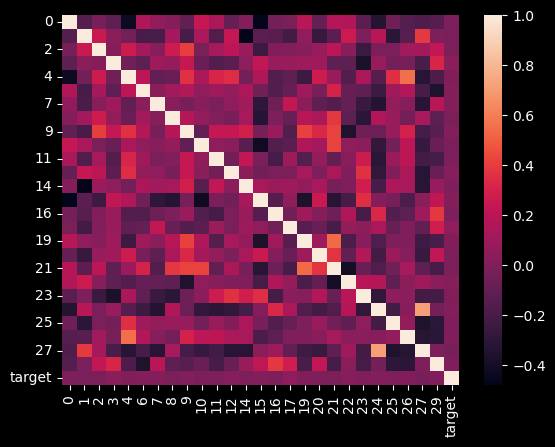

In [4]:
sns.heatmap(tr.corr())

In [5]:
for column in set(tr.columns) & set(tst.columns):
    pvalue = kstest(tr[column], tst[column]).pvalue
    if pvalue <= 0.05:
        print(column, pvalue)

In [6]:
X, y = (
    tr.drop(["target"], axis = 1),
    tr["target"],
)

In [32]:
columns = X.columns.to_list()
columns.append('EM')


In [7]:
columns = X.columns
X_new = X.copy()
for column1 in columns:
    for column2 in columns:
        if column1 != column2:
            X_new[f'{column1}' + '*' + f'{column2}'] = X[column1] * X[column2]



columns = tst.columns
tst_new = tst.copy()
for column1 in columns:
    for column2 in columns:
        if column1 != column2:
            tst_new[f'{column1}' + '*' + f'{column2}'] = tst[column1] * tst[column2]

In [8]:
X_tr, X_val, y_tr, y_val = train_test_split(X_new, y, test_size=0.2, random_state=42)
X_tr_, X_val_, _, _ = train_test_split(X, y, test_size=0.2, random_state=42)


In [9]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=4, random_state=42).fit(X_tr_)

X_tr['EM'] = gm.predict(X_tr_)
X_val['EM'] = gm.predict(X_val_)

tst_new['EM'] = gm.predict(tst)

<Axes: xlabel='EM', ylabel='Count'>

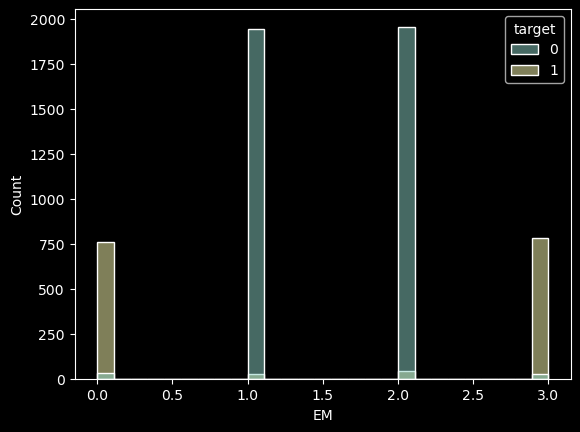

In [10]:
import seaborn as sns


sns.histplot(data = X_tr, x = 'EM', hue = y_tr)

In [16]:
params = {
    "boosting_type": "dart",
    "objective": "binary",
    "metric": ["auc", ""],
    "learning_rate": 0.12844630277246294,
    #
    "verbosity": -1,
    "random_state": 42,
    'max_depth': 12,
}

with mlflow.start_run(run_name="Baseline"):
    model = lgb.train(
        params,
        train_set=lgb.Dataset(X_tr, y_tr, free_raw_data=True),
        num_boost_round=400,
        valid_sets=[lgb.Dataset(X_val, y_val, free_raw_data=True)],
        valid_names=["Validation"],
    )

In [18]:
y_val_probas = model.predict(X_val)
best = (0, 0)
for threshold in np.linspace(0, 1, 101):
    best = max(best, (f1_score(y_val, (y_val_probas > threshold)), threshold))
print(best)

(0.9550706033376123, 0.13)


In [ ]:
X_tr

In [18]:
pl.DataFrame(model.predict(tst_new) > best[1], schema={"target": pl.Int64}).write_csv(
    "./baseline_submission_2.csv"
)

# Optuna


In [28]:
import optuna
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.mixture import GaussianMixture
from sklearn.naive_bayes import BernoulliNB
from catboost import Pool, CatBoostClassifier


def objective(trial, X_tr, y_tr, X_val, y_val, columns):
    '''
    function of objective loss(returns objective loss for log regrression) with suggested parameters
    '''
    params = {'objective': 'binary', 
              'metric': 'binary_logloss', 
              'eta': 0.12, 
              'max_depth': 8,
              'verbosity': -1, 
              'num_boost_round':100,
              'random_state': 42,
              }
    
    
    
    alpha_lgb = trial.suggest_float('alpha_lgb', 0, 1)
    alpha_svc = trial.suggest_float('alpha_svc', 0, 1)
    alpha_log = trial.suggest_float('alpha_log', 0, 1)
    alpha_gauss = trial.suggest_float('alpha_gauss', 0, 1)
    alpha_ber = trial.suggest_float('alpha_ber', 0, 1)
    
    
    dataset = lgb.Dataset(X_tr, y_tr)
    lgb_model = lgb.train(params, dataset)
    y_lgb = lgb_model.predict(X_val)
    
    
    SVC_model = SVC(C = 0.7, kernel='rbf', random_state = 42, probability = True).fit(X_tr[columns], y_tr)
    y_SVC = SVC_model.predict_proba(X_val[columns])[:, 1]
    
    
    Log_model = LogisticRegression(penalty = 'l1', random_state = 42, solver = 'liblinear').fit(X_tr, y_tr)
    y_log = Log_model.predict_proba(X_val)[:, 1]

    
    
    gauss_model = GaussianNB().fit(X_tr, y_tr)
    y_gauss = gauss_model.predict_proba(X_val)[:, 1]

    
    bernulli_model = BernoulliNB().fit(X_tr, y_tr)
    y_ber = bernulli_model.predict_proba(X_val)[:, 1]
    
    
    
    y_final = alpha_lgb * y_lgb + alpha_svc * y_SVC + alpha_log * y_log + alpha_gauss * y_gauss + alpha_ber * y_ber
    score = roc_auc_score(y_val, y_final)
    

        
    



    return score

In [29]:
from functools import partial

def start_optimization(
    objective_func, # принимает trial, X_tr, y_tr, X_val, y_val, **other_objective_kwargs
    n_trials,
    n_jobs,
    X_tr, 
    y_tr, 
    X_val, 
    y_val,
    columns,
    study_direction=None,
    sampler=None,
    features=None,
    **other_objective_kwargs
):

    obj_func = partial(objective_func, X_tr=X_tr, 
                       X_val=X_val, 
                       y_tr=y_tr, 
                       y_val=y_val, columns = columns)
    study = optuna.create_study(sampler=sampler, direction='maximize')
    study.optimize(obj_func, n_trials=n_trials, n_jobs= n_jobs)
    return study

In [33]:
tpe_sampler = optuna.samplers.TPESampler(
        n_startup_trials= 20, # объем разведки. Всегда настраивайте!
        n_ei_candidates=16, # влияет на "точность шага"
)
study = start_optimization(objective, n_trials = 50, n_jobs = -1,tpe_sampler = tpe_sampler, X_tr = X_tr, 
                           y_tr = y_tr,
                          X_val = X_val,
                          y_val = y_val,
                          columns=columns)

[I 2024-04-18 19:06:08,810] A new study created in memory with name: no-name-2fdd8d5b-537e-48f5-8614-eefb05097664
[I 2024-04-18 19:06:57,593] Trial 4 finished with value: 0.9866762638406054 and parameters: {'alpha_lgb': 0.749990207090623, 'alpha_svc': 0.16952496735322853, 'alpha_log': 0.46286265477341104, 'alpha_gauss': 0.06465906236988705, 'alpha_ber': 0.043134499994185505}. Best is trial 4 with value: 0.9866762638406054.
[I 2024-04-18 19:06:58,220] Trial 3 finished with value: 0.9835903640289753 and parameters: {'alpha_lgb': 0.9723284972423962, 'alpha_svc': 0.031024163177463593, 'alpha_log': 0.22337673323577767, 'alpha_gauss': 0.17184753100191097, 'alpha_ber': 0.5158683743510902}. Best is trial 4 with value: 0.9866762638406054.
[I 2024-04-18 19:06:58,273] Trial 5 finished with value: 0.9550770581598951 and parameters: {'alpha_lgb': 0.1749469308166427, 'alpha_svc': 0.24028624990854508, 'alpha_log': 0.5196915216256868, 'alpha_gauss': 0.9230309412378332, 'alpha_ber': 0.43833877650290654

In [34]:
weights = study.best_params

In [35]:
weights

{'alpha_lgb': 0.7659549128900517,
 'alpha_svc': 0.4191003508625777,
 'alpha_log': 0.38378218864614627,
 'alpha_gauss': 0.008251912475198554,
 'alpha_ber': 0.01152695938769277}

In [36]:
params = {'objective': 'binary', 
              'metric': 'binary_logloss', 
              'eta': 0.12, 
              'max_depth': 8,
              'verbosity': -1, 
              'num_boost_round':100,
              'random_state': 42,
              }
    
    
    
alpha_lgb = weights['alpha_lgb']
alpha_svc = weights['alpha_svc']
alpha_log = weights['alpha_log']
alpha_gauss = weights['alpha_gauss']
alpha_ber = weights['alpha_ber']

dataset = lgb.Dataset(X_tr, y_tr)
lgb_model = lgb.train(params, dataset)
y_lgb = lgb_model.predict(X_val)
    
    
SVC_model = SVC(C = 0.7, kernel='rbf', random_state = 42, probability = True).fit(X_tr[columns], y_tr)
y_SVC = SVC_model.predict_proba(X_val[columns])[:, 1]
    
    
Log_model = LogisticRegression(penalty = 'l1', random_state = 42, solver = 'liblinear').fit(X_tr, y_tr)
y_log = Log_model.predict_proba(X_val)[:, 1]

    
    
gauss_model = GaussianNB().fit(X_tr, y_tr)
y_gauss = gauss_model.predict_proba(X_val)[:, 1]

    
bernulli_model = BernoulliNB().fit(X_tr, y_tr)
y_ber = bernulli_model.predict_proba(X_val)[:, 1]
    
    
    
y_final = alpha_lgb * y_lgb + alpha_svc * y_SVC + alpha_log * y_log + alpha_gauss * y_gauss + alpha_ber * y_ber


In [40]:
y_final

array([0.05229534, 1.5572143 , 0.01989572, ..., 0.00172616, 0.04116537,
       0.63232229])

In [42]:
y_val_probas = y_final
best = (0, 0)
for threshold in np.linspace(0, 1, 10000):
    best = max(best, (f1_score(y_val, (y_val_probas > threshold)), threshold))
print(best)

(0.9537275064267352, 0.7907790779077908)


In [43]:
pl.DataFrame(model.predict(tst_new) > best[1], schema={"target": pl.Int64}).write_csv(
    "./baseline_submission_3.csv"
)